# Module Import

In [1]:
!pip install xgboost==1.6.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 192.9/192.9 MB 3.5 MB/s eta 0:00:00
  Attempting uninstall: xgboost
    Found existing installation: xgboost 2.0.0
    Uninstalling xgboost-2.0.0:
      Successfully uninstalled xgboost-2.0.0


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Dataset Import

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


The overall dataset has already been split into 70% train and 30% test datasets.

In [4]:
train_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/train.csv")
test_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/test.csv")

In [5]:
train_df.head()

,CTR,titleWords,adWords,depth,position,advCTR,advCTRInPos,queryCTR,queryCTRInPos,gender,age
0,0.0000,10,17,3,2,0.0136,0.0146,0.0000,0.0000,male,41+
1,0.0761,13,30,2,1,0.0373,0.0465,0.0382,0.0581,male,13-18
2,0.0426,12,14,1,1,0.0254,0.0310,0.0255,0.0323,male,13-18
3,0.0000,5,19,3,2,0.0178,0.0076,0.0035,0.0017,female,25-30
4,0.0068,11,17,2,2,0.0096,0.0069,0.0294,0.0171,female,19-24


In [6]:
y_train = train_df.pop('CTR')
y_test = test_df.pop('CTR')

# Helper Functions

We will use some functions to evaluate results:


*   MAE (mean absolute error)
*   RMSE (root mean squared error)
*   OSR2 (out of sample R2)

We will apply these to the test set always so that our metrics are out-of-sample

In [7]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

def OSR2(y_true, y_pred, training_mean):
  '''
  Calculates out-of-sample R-squared
  '''
  baseline_error = np.sum(np.square((training_mean - y_true)))
  model_error = np.sum(np.square((y_pred - y_true)))
  return 1.0 - model_error/baseline_error


def calc_metrics():
  print(f'OSR2: {OSR2(y_test, y_pred, y_train.mean()):.3f}')
  print(f'MAE: {mean_absolute_error(y_test, y_pred):.3f}')
  print(f'RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.3f}')


# Linear Regression

In [8]:
train = train_df.copy()
test = test_df.copy()
train = pd.get_dummies(train, columns=['age','gender'], drop_first=True)
test = pd.get_dummies(test, columns=['age','gender'], drop_first=True)

In [9]:
train.head()

,titleWords,adWords,depth,position,advCTR,advCTRInPos,queryCTR,queryCTRInPos,age_13-18,age_19-24,age_25-30,age_31-40,age_41+,age_unknown,gender_male,gender_unknown
0,10,17,3,2,0.0136,0.0146,0.0000,0.0000,0,0,0,0,1,0,1,0
1,13,30,2,1,0.0373,0.0465,0.0382,0.0581,1,0,0,0,0,0,1,0
2,12,14,1,1,0.0254,0.0310,0.0255,0.0323,1,0,0,0,0,0,1,0
3,5,19,3,2,0.0178,0.0076,0.0035,0.0017,0,0,1,0,0,0,0,0
4,11,17,2,2,0.0096,0.0069,0.0294,0.0171,0,1,0,0,0,0,0,0


In [10]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(train, y_train)
y_pred = model.predict(test)
calc_metrics()

OSR2: 0.375
MAE: 0.036
RMSE: 0.060


In [11]:
pd.DataFrame({"Variable": train.columns, "Coefficient": model.coef_})

,Variable,Coefficient
0,titleWords,-0.000522
1,adWords,0.000384
2,depth,0.001969
3,position,-0.006381
4,advCTR,0.448779
5,advCTRInPos,0.557652
6,queryCTR,0.008432
7,queryCTRInPos,0.459923
8,age_13-18,-0.000537
9,age_19-24,-0.004222


# CART for Regression

In [12]:
train = train_df.copy()
test = test_df.copy()
train = pd.get_dummies(train, columns=['age','gender'])
test = pd.get_dummies(test, columns=['age','gender'])

In [13]:
from sklearn.tree import DecisionTreeRegressor

Let's train a full tree first.

In [14]:
tree = DecisionTreeRegressor(random_state=42).fit(train,y_train)
y_pred = tree.predict(test)
calc_metrics()

OSR2: 0.110
MAE: 0.041
RMSE: 0.072


Really bad!

In [15]:
tree = DecisionTreeRegressor(random_state=42)
path = tree.cost_complexity_pruning_path(train, y_train)

In [16]:
alphas = path.ccp_alphas

In [17]:
alphas[-10:]

array([5.60594121e-05, 6.78182339e-05, 7.82438153e-05, 9.48639975e-05,
       1.10524275e-04, 1.21605695e-04, 1.42269318e-04, 2.12454597e-04,
       3.79581119e-04, 1.54424559e-03])

In [18]:
len(alphas)

3269

That's a lot of possible pruned trees. Let's select every 10th tree so that we get ~330 trees in total.

In [19]:
alphas = alphas[::10]

In [20]:
len(alphas)

327

In [21]:
osr2_all = []

for alpha in alphas:
  tree = DecisionTreeRegressor(ccp_alpha=alpha, random_state=42).fit(train,y_train)
  y_pred = tree.predict(test)
  osr2 = OSR2(y_test, y_pred, y_train.mean())
  osr2_all.append(osr2)

What's the best OSR2?

In [22]:
np.max(osr2_all)

0.37074956875052256

Nice improvement!

In [23]:
opt_alpha = alphas[np.argmax(osr2_all)]

In [24]:
tree = DecisionTreeRegressor(ccp_alpha=opt_alpha, random_state=42).fit(train,y_train)
y_pred = tree.predict(test)
calc_metrics()

OSR2: 0.371
MAE: 0.035
RMSE: 0.060


Very nice!

How big is this tree?

In [25]:
tree.tree_.node_count, tree.tree_.max_depth

(41, 8)

In [26]:
from sklearn.tree import plot_tree

In [27]:
def viz_tree(tree, X, font=12, figsize=(16,10)):
  '''
  draws a CART tree
  '''
  plt.figure(figsize=figsize)  # set plot size (denoted in inches)
  _ = plot_tree(tree,
                feature_names=X.columns,
                filled=True,
                fontsize=font)

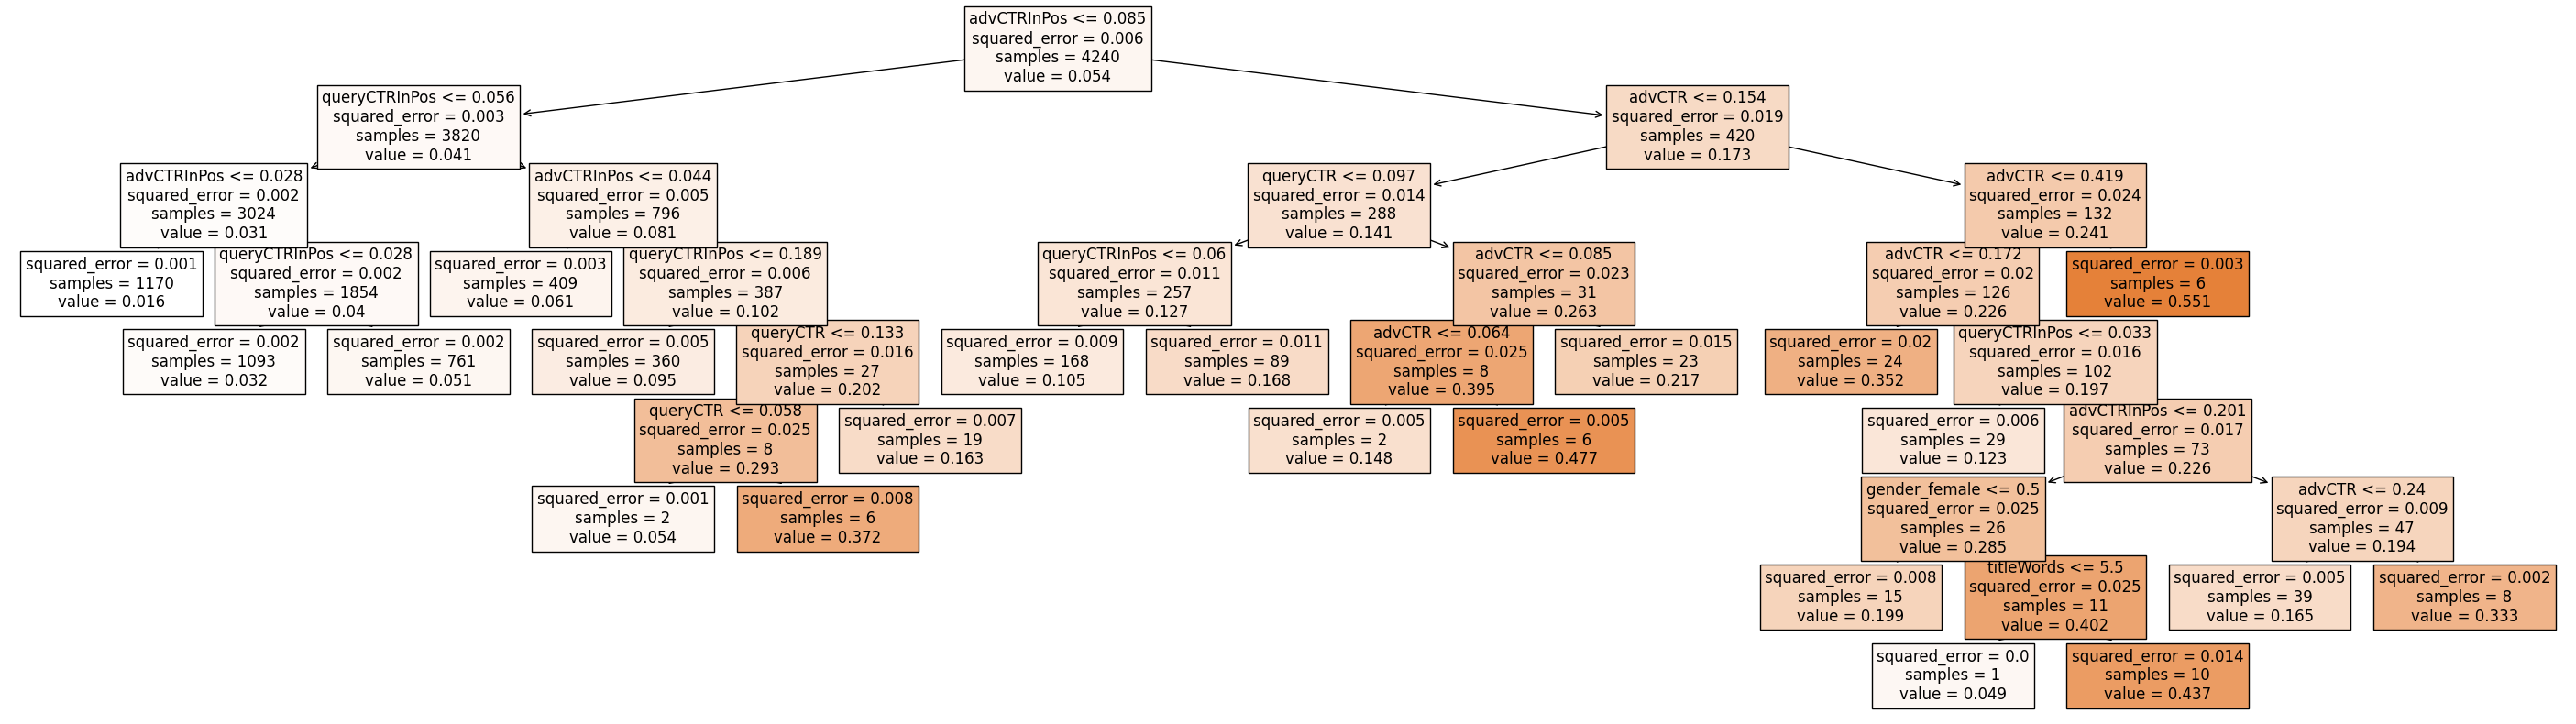

In [28]:
viz_tree(tree, train, figsize=(36,10))

# Random Forests

In [29]:
from sklearn.ensemble import RandomForestRegressor

Let's train a Random Forest model with all default settings.

In [30]:
rf = RandomForestRegressor(random_state=42).fit(train,y_train)
y_pred = rf.predict(test)
calc_metrics()

OSR2: 0.467
MAE: 0.032
RMSE: 0.056


That handily outperforms Linear Regression and CART.

# XGBoost!

In [31]:
import xgboost
print(xgboost.__version__)

1.6.1


In [32]:
from xgboost import XGBRegressor

In [33]:
model = XGBRegressor(random_state=42)

Let's train an XGBoost model with all default settings.

In [34]:
model.fit(train, y_train)
y_pred = model.predict(test)

In [35]:
calc_metrics()

OSR2: 0.441
MAE: 0.033
RMSE: 0.057


# Hyperparameter Optimization

## Grid Search

In [36]:
from sklearn.model_selection import GridSearchCV

Let's vary *three* hyperparameters simultaneously:

*   number of trees `n_estimators`: 10, 50, 100
*   maximum depth of the tree `max_depth`: 1,2,3,4,5
*   learning rate/shrinkage parameter $\eta$ i.e., `learning_rate`: 0.001, 0.01, 0.1, 0.3

This generates 60 hyperparameter combinations. For each, we will do 5-fold CV. So, an XGBoost model will be trained 300 times!



In [37]:
param_grid = {'n_estimators': [10,50,100],
              'max_depth': [1,2,3,4,5],
              'learning_rate': [0.001, 0.01, 0.1, 0.3]}

In [38]:
model = XGBRegressor(random_state=42)

In [39]:
gcv = GridSearchCV(model,
                  param_grid=param_grid,
                  cv=5,
                  scoring='neg_mean_absolute_error')

In [40]:
gcv.fit(train, y_train)

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    gamma=None, gpu_id=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_bin=None,
                                    max_cat...None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=42,
                                    reg_alpha=None, reg_lambda=None, ...),
             param_grid={'learning_rate': [0.001, 0.01, 0.1, 0.3],
                         'max_depth': [1, 2, 3, 4, 5],
                         'n_estimators': [10, 50, 100]},
             scoring='neg_mean_absolute_error')

What's the combination with the lowest MAE?

In [41]:
gcv.best_params_

{'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100}

In [42]:
y_pred = gcv.best_estimator_.predict(test)
calc_metrics()

OSR2: 0.485
MAE: 0.032
RMSE: 0.055


## Random Search

In [43]:
from sklearn.model_selection import RandomizedSearchCV

In [44]:
model = XGBRegressor(random_state=42)

In [45]:
param_grid = {'n_estimators': range(10,1010,10),
              'max_depth': range(1,21),
              'learning_rate': np.linspace(0.001, 1.0, 50)}

**That**'s 100 x 20 x 50 = 100,000 combinations! We will try only 10 of these combinations using `RandomizedSearch`.

In [46]:
rcv = RandomizedSearchCV(model,
                        param_distributions = param_grid,
                        cv=5,
                        n_iter=10,
                        scoring='neg_mean_absolute_error',
                        random_state=42)

In [47]:
rcv.fit(train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, gamma=None,
                                          gpu_id=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=None, max_bin=None,
                                          m...
       0.51069388, 0.53108163, 0.55146939, 0.57185714, 0.5922449 ,
       0.61263265, 0.63302041, 0.65340816, 0.67379592, 0.69418367,
       0.71457143, 0.73495918, 0.75534694, 0.77573469, 0.79612245,
       0.8165102 , 0.83689796, 0.85728571, 0.87767347, 0.89806122,
       0.91844898, 0.93883673, 0.95922449, 0.97961224, 1.        ]),
                                        'max_depth': range(1, 21),
                                        'n_estimators': range(10, 1010, 10)},
                   random_state=42, scoring='neg_mean_absolute_error')

In [48]:
rcv.best_params_

{'n_estimators': 660, 'max_depth': 3, 'learning_rate': 0.062163265306122456}

In [49]:
y_pred = rcv.best_estimator_.predict(test)
calc_metrics()

OSR2: 0.493
MAE: 0.031
RMSE: 0.054




---



---


**SUMMARY**

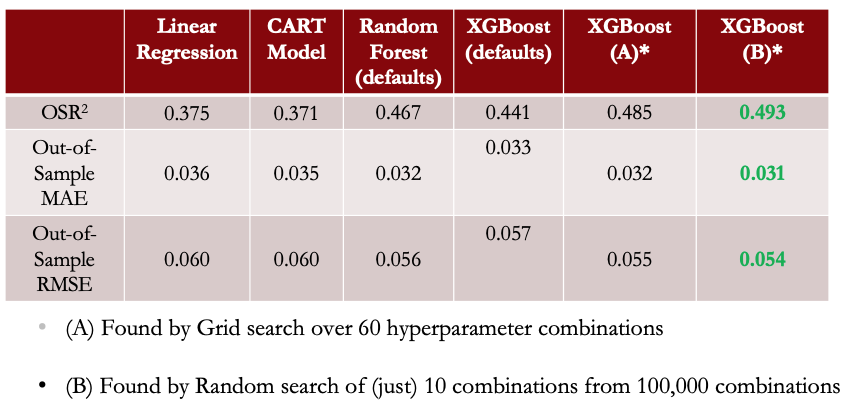



---



---



In [50]:
pd.DataFrame(rcv.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_max_depth,param_learning_rate,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,4.883540,1.316628,0.014004,0.000263,960,18,0.143714,"{'n_estimators': 960, 'max_depth': 18, 'learni...",-0.038162,-0.034274,-0.033324,-0.032143,-0.031907,-0.033962,0.002266,3
1,5.303355,1.363696,0.020526,0.009929,610,9,0.001,"{'n_estimators': 610, 'max_depth': 9, 'learnin...",-0.241553,-0.243169,-0.243082,-0.248784,-0.251776,-0.245673,0.003921,10
2,0.965418,0.006377,0.008363,0.000559,210,9,0.775735,"{'n_estimators': 210, 'max_depth': 9, 'learnin...",-0.043771,-0.039320,-0.039189,-0.036754,-0.036275,-0.039062,0.002659,7
3,3.897910,1.181456,0.016278,0.012164,870,9,0.551469,"{'n_estimators': 870, 'max_depth': 9, 'learnin...",-0.039687,-0.035537,-0.036683,-0.034356,-0.034065,-0.036066,0.002035,5
4,3.151448,1.090846,0.011450,0.000132,660,3,0.062163,"{'n_estimators': 660, 'max_depth': 3, 'learnin...",-0.034834,-0.032301,-0.032642,-0.031083,-0.030971,-0.032366,0.001397,1
5,4.402417,1.016928,0.022463,0.010548,870,4,0.836898,"{'n_estimators': 870, 'max_depth': 4, 'learnin...",-0.046309,-0.039402,-0.038848,-0.036955,-0.037948,-0.039892,0.003314,9
6,3.796480,1.010302,0.012866,0.004168,950,12,0.36798,"{'n_estimators': 950, 'max_depth': 12, 'learni...",-0.039787,-0.033698,-0.033791,-0.032605,-0.033658,-0.034708,0.002576,4
7,3.416203,1.071284,0.009661,0.001111,990,15,0.877673,"{'n_estimators': 990, 'max_depth': 15, 'learni...",-0.045782,-0.040443,-0.038307,-0.037943,-0.036457,-0.039786,0.003257,8
8,2.150367,1.210159,0.009630,0.002245,320,2,0.449531,"{'n_estimators': 320, 'max_depth': 2, 'learnin...",-0.037378,-0.033759,-0.033921,-0.031456,-0.032462,-0.033795,0.002005,2
9,3.052955,1.086124,0.011247,0.000317,640,3,0.612633,"{'n_estimators': 640, 'max_depth': 3, 'learnin...",-0.040711,-0.036928,-0.037833,-0.033884,-0.035008,-0.036873,0.002369,6


In [51]:
from xgboost import plot_importance

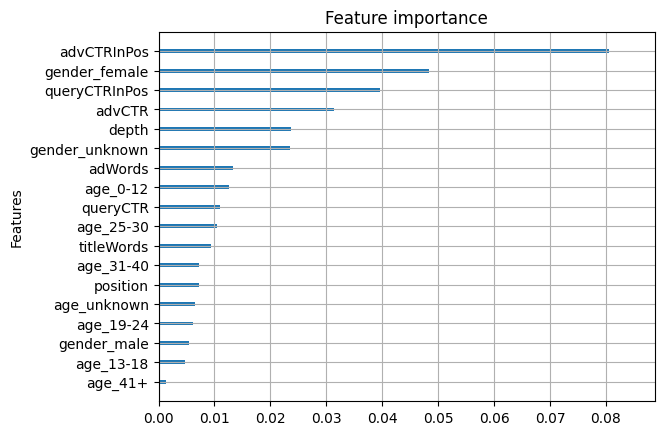

In [52]:
plot_importance(rcv.best_estimator_, importance_type='gain', show_values=False, xlabel='');

## Next Steps

We invite you to:

*   try different hyperparameter combinations and improve upon these metrics
*   apply the same techniques – Cross-Validation, Grid Search and Random Search – to find good hyperparameter combinations for Random Forests as well.
